# Tutorial 05.3 - Using Generators for data pre-processing and labeling

## Setup DevCube GPU

Before you can start, you have to find a GPU on the system that is not heavily used by other users. Otherwise you cannot initialize your neural network.


**Hint:** the command is **nvidia-smi**, just in case it is displayed above in two lines because of a line break.

As a result you get a summary of the GPUs available in the system, their current memory usage (in MiB for megabytes), and their current utilization (in %). There should be six or eight GPUs listed and these are numbered 0 to n-1 (n being the number of GPUs). The GPU numbers (ids) are quite at the beginning of each GPU section and their numbers increase from top to bottom by 1.

Find a GPU where the memory usage is low. For this purpose look at the memory usage, which looks something like '365MiB / 16125MiB'. The first value is the already used up memory and the second value is the total memory of the GPU. Look for a GPU where there is a large difference between the first and the second value.

**Remember the GPU id and write it in the next line instead of the character X.**

In [1]:

# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 0

In [ ]:
# !nvidia-smi

### Choose one GPU

**The following code is very important and must always be executed before using TensorFlow in the exercises, so that only one GPU is used and that it is set in a way that not all its memory is used at once. Otherwise, the other students will not be able to work with this GPU.**

The following program code imports the TensorFlow library for Deep Learning and outputs the version of the library.

Then, TensorFlow is configured to only see the one GPU whose number you wrote in the above cell (USE_GPU = X) instead of the X.

Finally, the GPU is set so that it does not immediately reserve all memory, but only uses more memory when needed. 

(The comments within the code cell explains a bit of what is happening if you are interested to better understand it. See also the documentation of TensorFlow for an explanation of the used methods.)

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
#tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.4.0

Available GPU Devices:

Visible GPU Devices:


In [3]:
# please run this cell in order to have the plots displayed in the notebook
%matplotlib inline

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Using Generators for data pre-processing and labeling

In this section you will be introduced the DataImageGenerator class, a TensorFlow built-in utility for fast dataset pre-processing.

### Learning Objectives:

+ understand TensorFlow Data Generators and configure them for training a model



### Data augmentation
Data augmentation is another regularization technique that encompasses a wide range of techniques used to generate “new” training samples from the original ones. The new samples are generated by applying random geometric and/or radiometric transformations and,  at the same time, ensuring that the transformed data preserves the class labels of the original data.

Our goal when applying data augmentation is to increase the transformation invariance of the model, e.g., given that our network is constantly seeing new, slightly modified versions of the input data, the network is able to learn more robust features.

At testing time we do not apply data augmentation and simply evaluate our trained network on the unmodified testing data — in most cases, one can notice an increase in testing accuracy, perhaps at the expense of a slight dip in training accuracy. Keras offers the built-in class [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?hl=hi) that allows dataset augmentation on the fly.

### Motivation for generators

So far we have worked with small datasets that allowed us to work by loading all the data in memory. Also, the MNIST and FASHION MNIST datasets, we have used so far, contained very uniform images, all of the same size. However, since the real datasets in Deep Learning are commonly large, this approach is not feasible.



That is the reason why we need to find other ways to do that task efficiently.
In this tutorial we will take a look at some of the APIs that are available in keras to make this task easier for us. In particular, the  build-in class `ImageDataGenerator`  in TensorFlow, which allows us to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.


## Data preprocessing

The `input` to a Keras model has to be `floating point tensors`. Often our data resides on the hard drive as _.png_ files or other file format, so the steps for getting it into our network are roughly:

* Read the image files.
* Decode the png content to RBG grids of pixels.
* Convert these into float32 tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (this leads to faster convergence of the optimization algorithm).
* Apply random transformations in order to augment the dataset (OPTIONALY)


TensorFlow submodule `keras.preprocessing.image` makes available the class [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?hl=en) which allows to:
* instantiate generators that can automatically  turn image files (and their labels) on disk into batches via `.flow(data, labels)` or `.flow_from_directory(directory)`
* configure *pre-processing operations* or *random transformations* to be applied on image data during training

These generators can then be used with the `Keras model methods` that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.



#### Dataset


To exemplify the usage of TensorFlow Data Generators we will use the Flowers dataset which can be downloaded from the TensoFlow datasets repository. It contains 2939 images in training and 731 images in the validation set. The images depict flowers belonging to 5 categories/classes.
Please retrieve further details about the dataset from the [official documentation](https://www.tensorflow.org/datasets/catalog/tf_flowers?hl=en)

## Setup Data Generators

Let's set up data generators that will:
 * read pictures in our source folders
 * convert them to float32 tensors
 * feed them (with their labels) to our network

We'll have one generator for the training images, one for the validation images. Our generators will yield batches of images of size (224, 224) and their categorical labels. One feature of the image generator is that we can point it at **a parent directory** (in our example called `data_dir`) and then the **sub-directories** of that will automatically **generate labels** for you. 
We can use the generaro in this way because the data was organized as in the image below: </br>

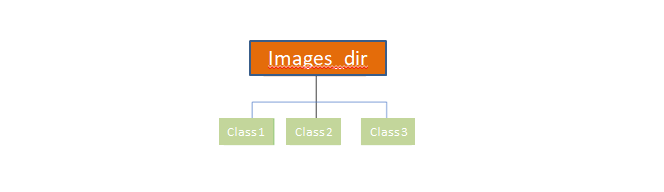

As already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a in a ANN.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of (augmented) image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [5]:

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

In [6]:
# download the data

data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 20s 0us/step


In [7]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

In [8]:
datagen_kwargs

{'rescale': 0.00392156862745098, 'validation_split': 0.2}

#### Setting up data generator for validation in two steps:
1) create a `_ImageDataGeneratorInstance_ passing in the folowing values for the arguments: </br>
+  rescaling factor </br>
+  the fraction for validation data

2) call the `flow_from_directory()` method to read the image files from the directory by pointing to the parent directory and passing in values for :</br>
+  subset (we specify that the data will be used for validation)
+  shuffle </br> 
+  target_size
+  batch_size
    
We assign this function to a variable that we will pass ín to the `fit` method.


In [9]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   rescale=1./255, validation_split=.20)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False,
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")


Found 731 images belonging to 5 classes.


#### Setting up data generator for training in two steps:
1) create a `_ImageDataGeneratorInstance_ passing in the folowing values for the arguments: </br>
+  rescaling factor </br>
+  the fraction for validation data
+  various values for a series of geometric transformations: rotation, flip, shift, shear, zoom

2) call the `flow_from_directory()` method to read the image files from the directory by pointing to the parent directory and passing in values for :</br>
+  subset (we specify that the data will be used for training)
+  shuffle </br> 
+  target_size
+  batch_size
    

We assign this function to a variable that we will pass ín to the `fit` method.

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255, validation_split=.2,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
     )

train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")



Found 2939 images belonging to 5 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, Flatten, BatchNormalization, Dropout
from tensorflow.keras.initializers import HeNormal

In [12]:
input_shape=(224,224,3)

model = Sequential()
model.add(Flatten(input_shape= input_shape))
model.add(Dense(128, kernel_initializer=HeNormal() ))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(256, kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(.05))
model.add(Dense(512, activation='relu', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(.05))
model.add(Dense(5, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0

In [14]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [15]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps)

Epoch 1/5
91/91 [==============================] - 48s 522ms/step - loss: 1.8013 - accuracy: 0.2869 - val_loss: 2.2115 - val_accuracy: 0.3082
Epoch 2/5
91/91 [==============================] - 33s 365ms/step - loss: 1.5474 - accuracy: 0.3817 - val_loss: 1.5181 - val_accuracy: 0.3835
Epoch 3/5
91/91 [==============================] - 33s 364ms/step - loss: 1.4536 - accuracy: 0.3948 - val_loss: 1.5859 - val_accuracy: 0.3849
Epoch 4/5
91/91 [==============================] - 33s 365ms/step - loss: 1.5033 - accuracy: 0.4090 - val_loss: 1.4501 - val_accuracy: 0.4375
Epoch 5/5
91/91 [==============================] - 33s 365ms/step - loss: 1.4838 - accuracy: 0.4251 - val_loss: 1.3983 - val_accuracy: 0.4503


## A closer look at training data generator

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    print('data example image shape:', data_batch[0].shape)
    print('data example label shape:', labels_batch[0].shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 5)
data example image shape: (224, 224, 3)
data example label shape: (5,)


The one-hot-encoded label of the plotted image is [0. 0. 0. 0. 1.]


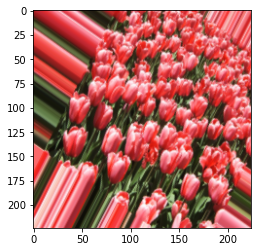

In [15]:
for data_batch, labels_batch in train_generator:
    plt.imshow(data_batch[0]) # Change 0 to a value between 0 and 19 to see other images within the batch
    print('The one-hot-encoded label of the plotted image is {}'.format(labels_batch[0]))
    break

### Further Reading

https://keras.io/api/preprocessing/image/#imagedatagenerator-class